**04b_model_output_analysis_validation**

- looked at misclassified patients by shap values for validation dataset

used this container: 
ml:1.0


In [4]:
# load packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import datetime

import pathlib

import shap

import tarfile
import pickle as pkl

import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import os
from urllib.parse import urlparse

from helper_functions import *

In [5]:
# define paths
base_dir = '/home/jovyan/work/Goldfinch/ML_paper/'
output_suffix = 'output_files/training_output/'
suffix = 'raw_data/intermediate_files/'

Accuracy: 82.02%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


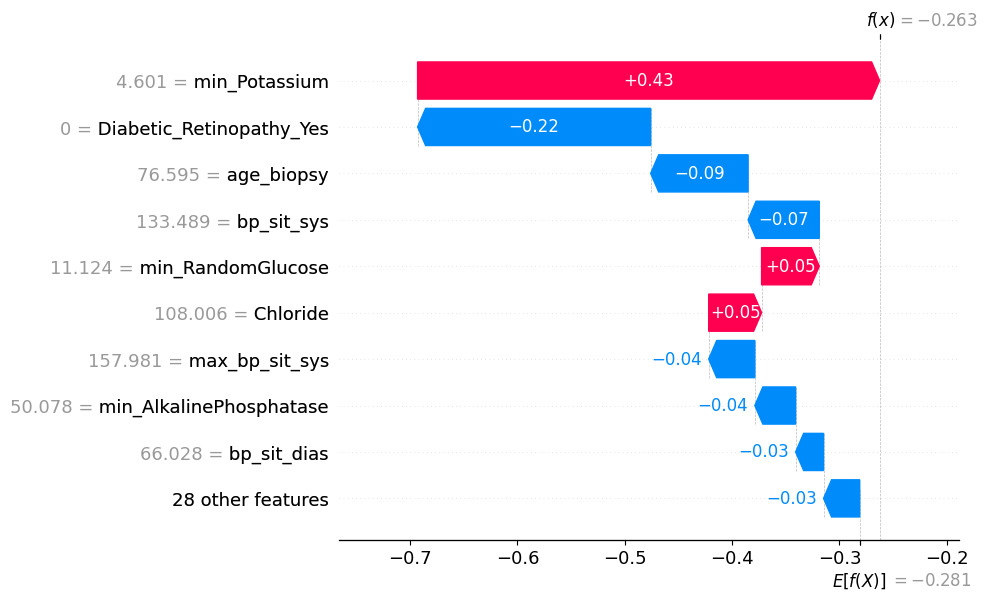

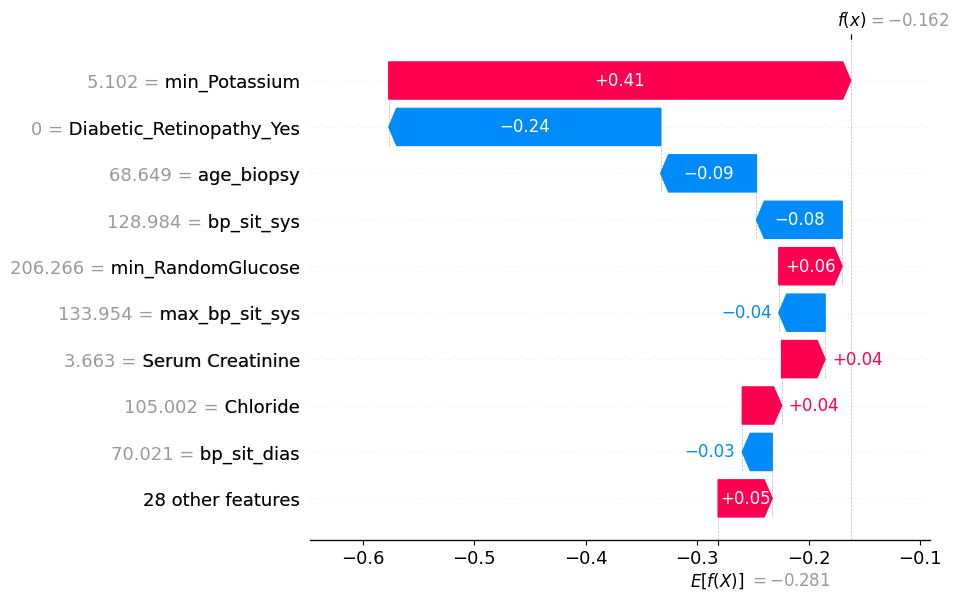

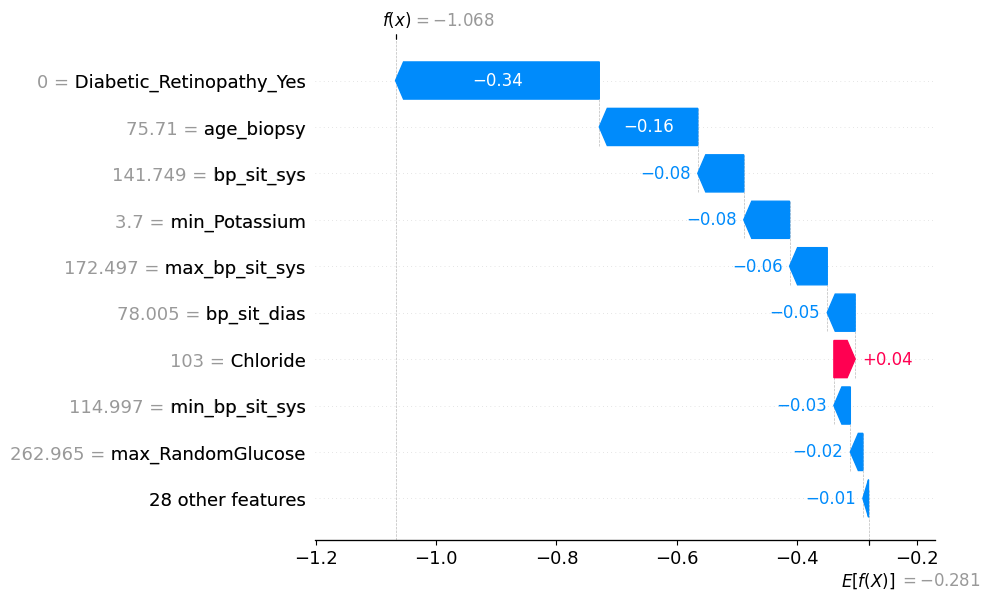

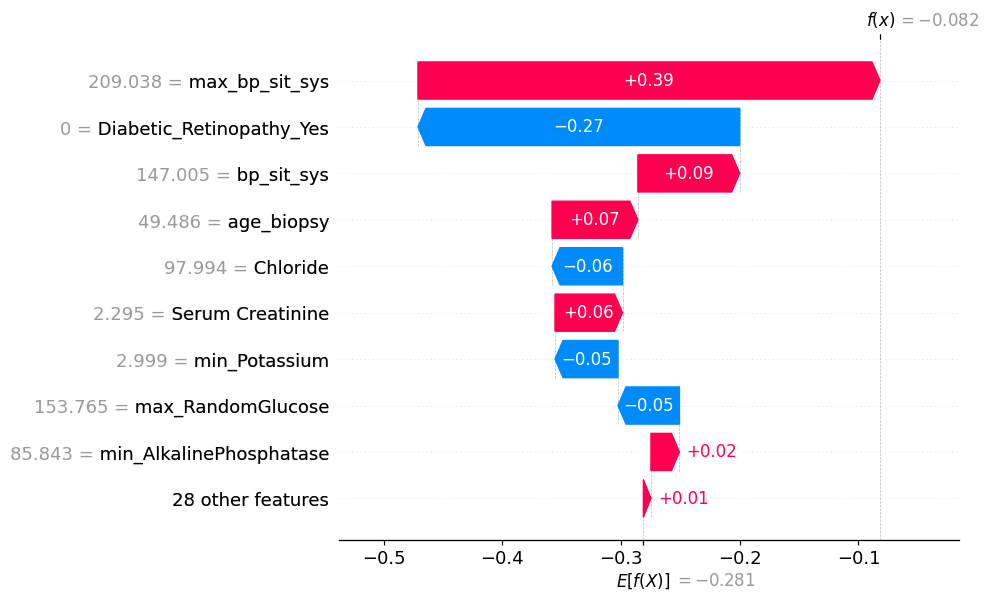

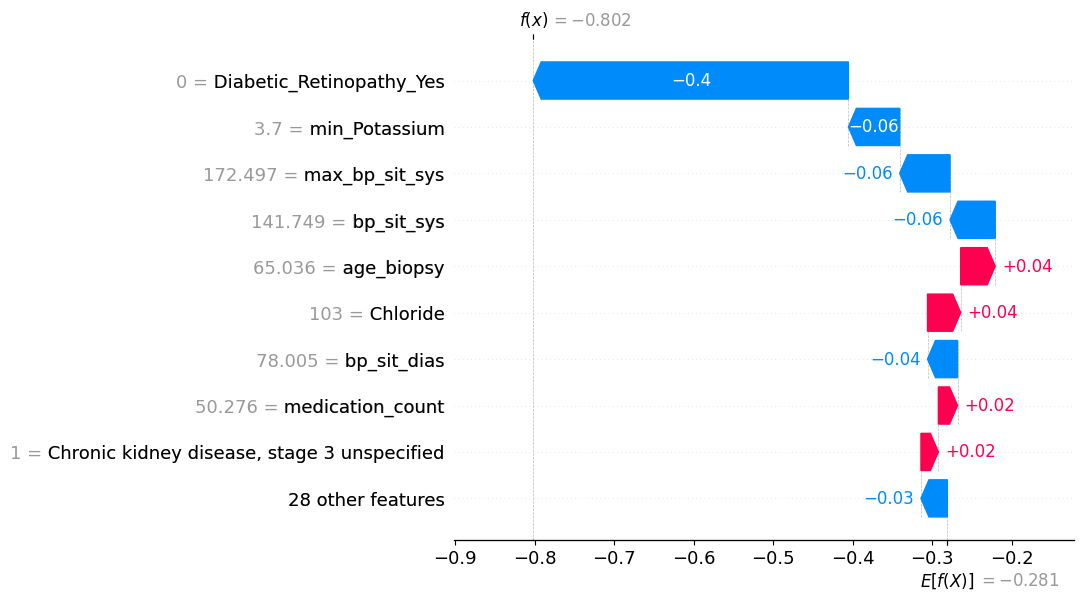

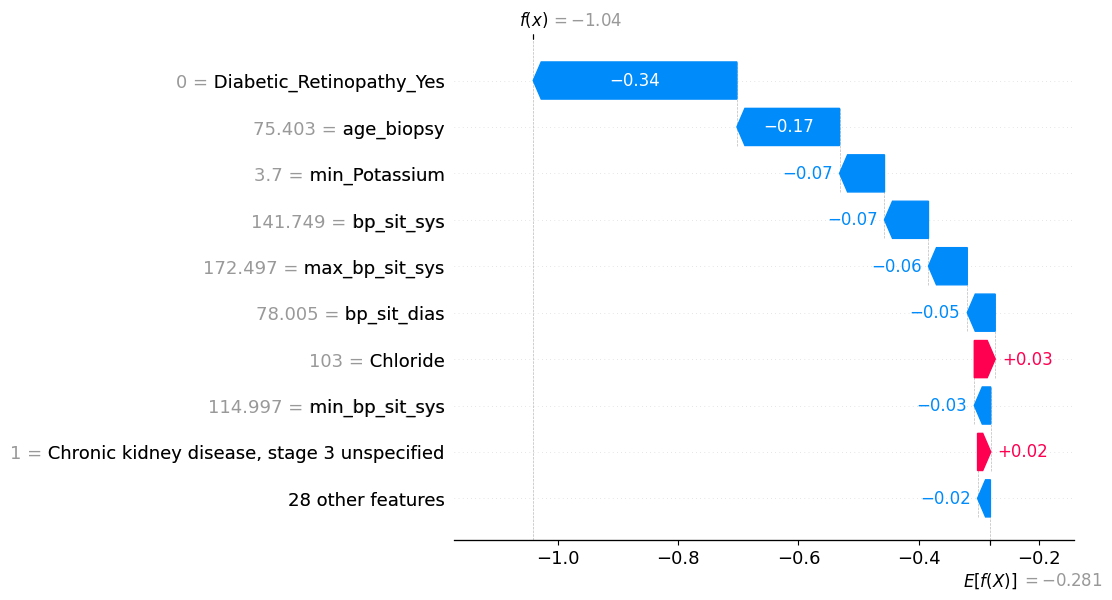

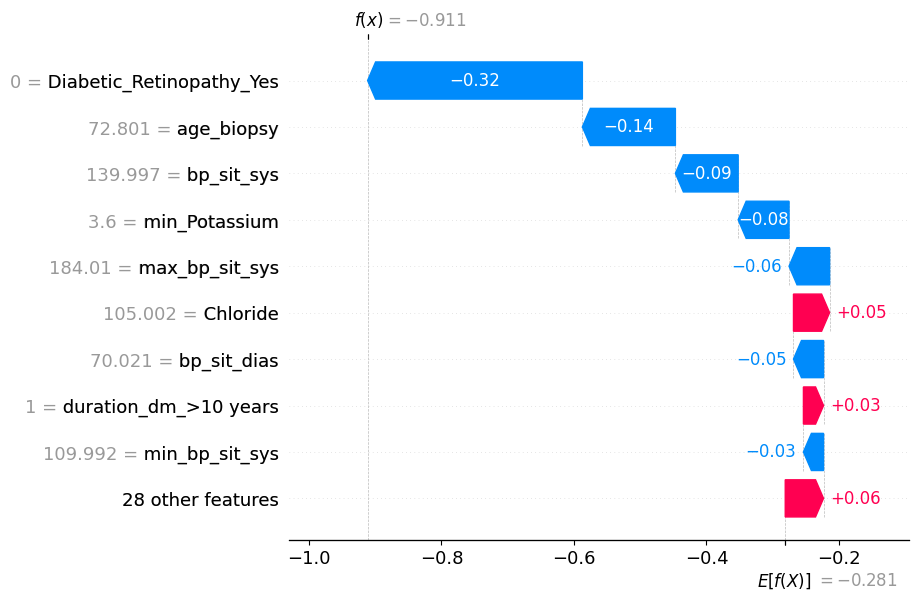

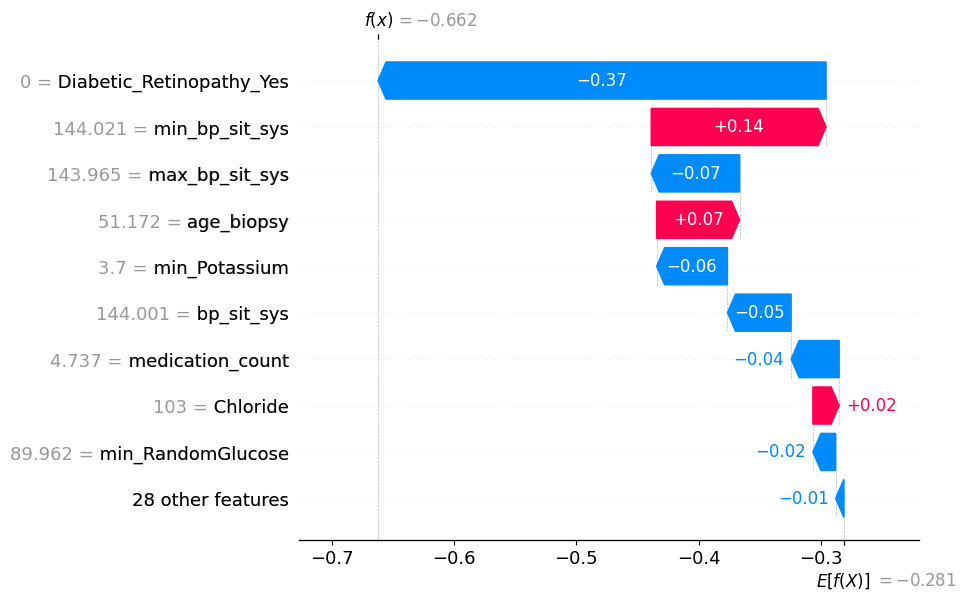

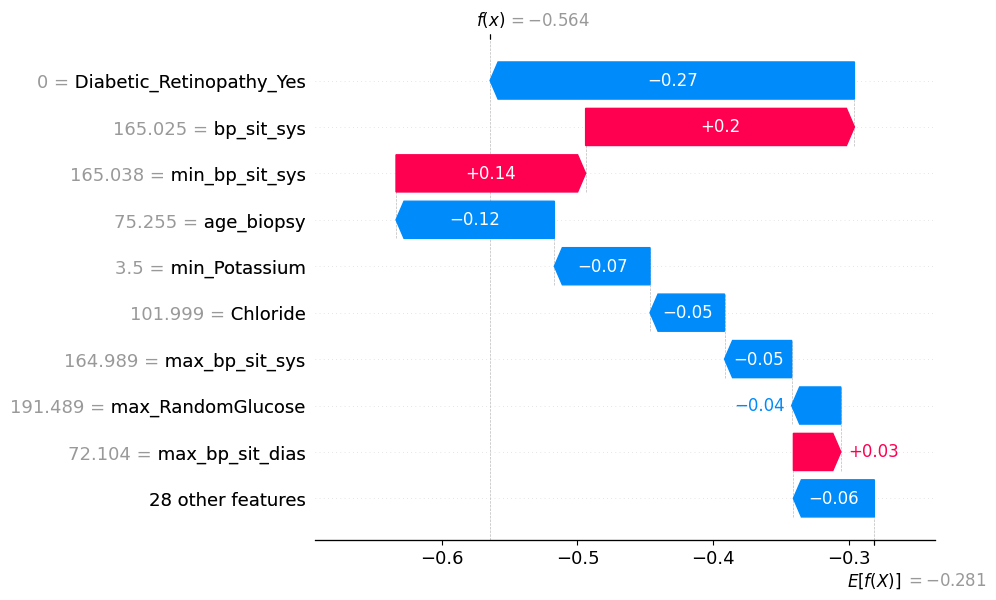

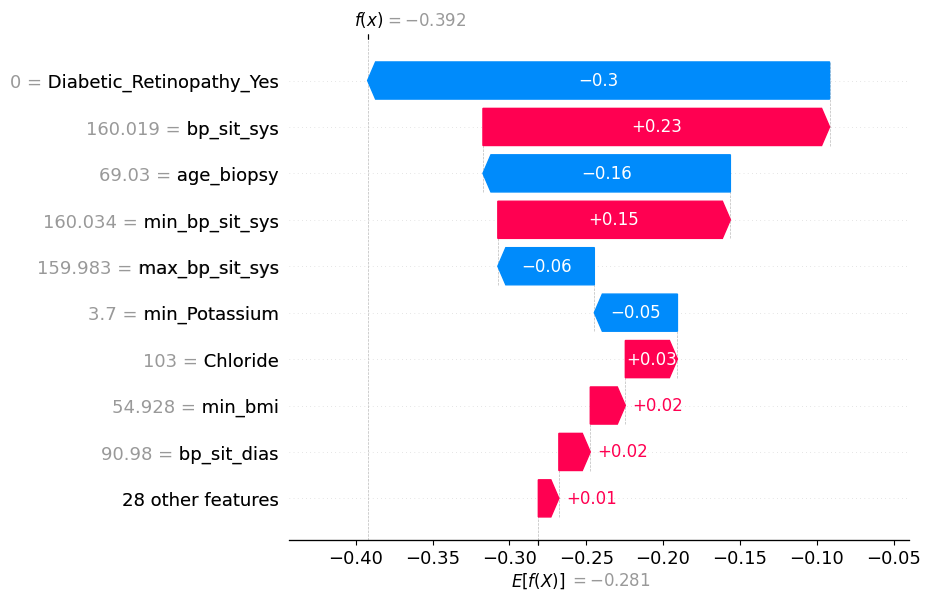

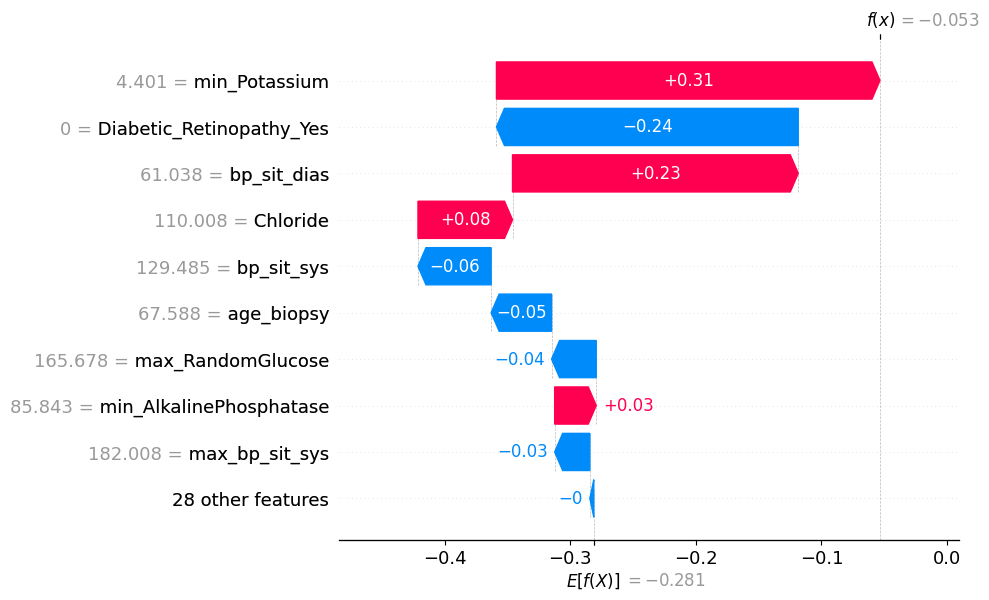

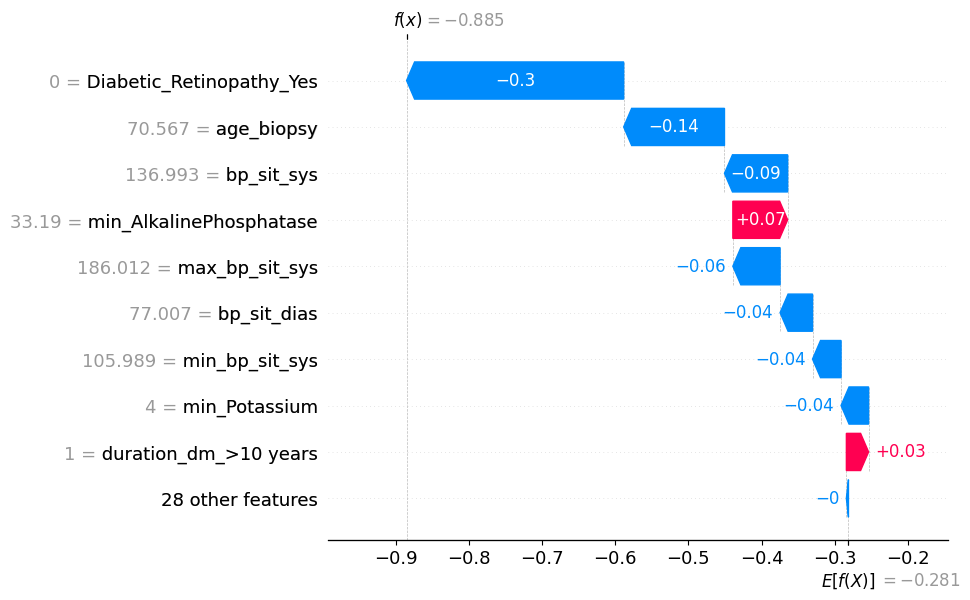

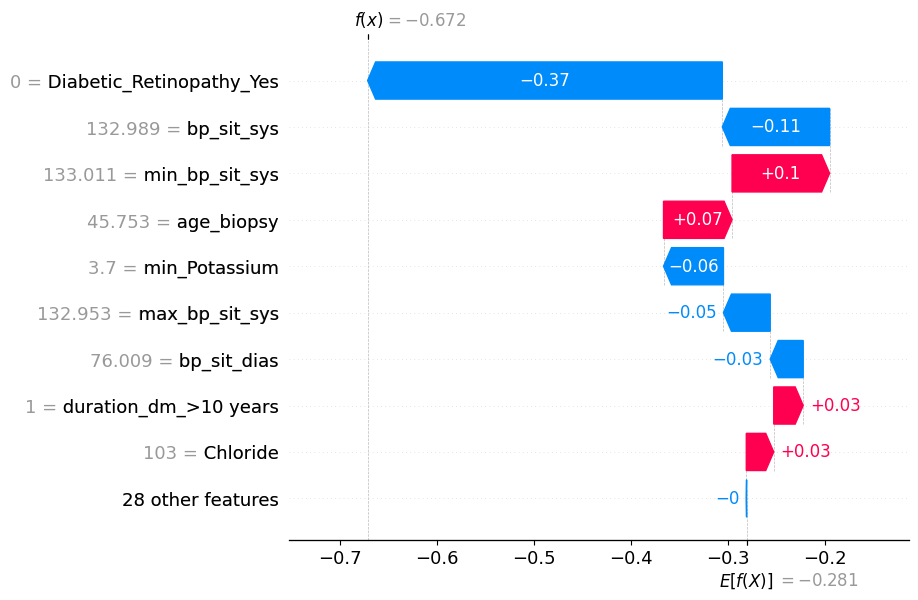

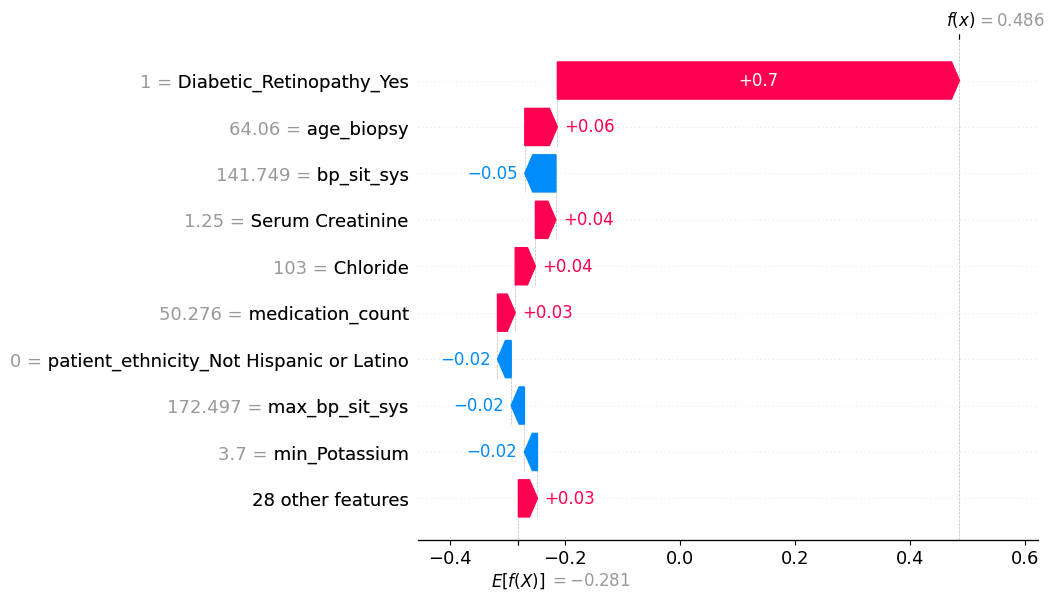

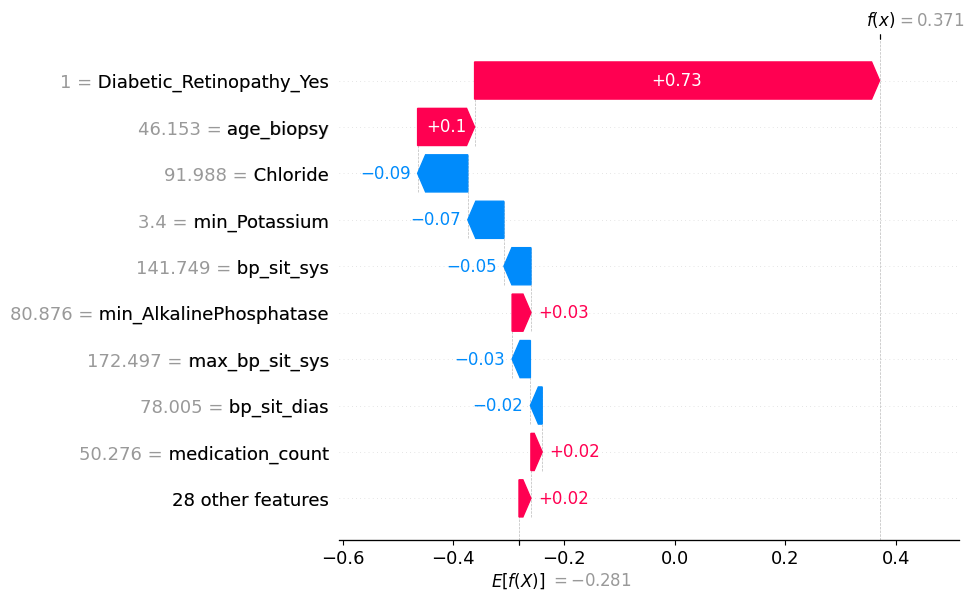

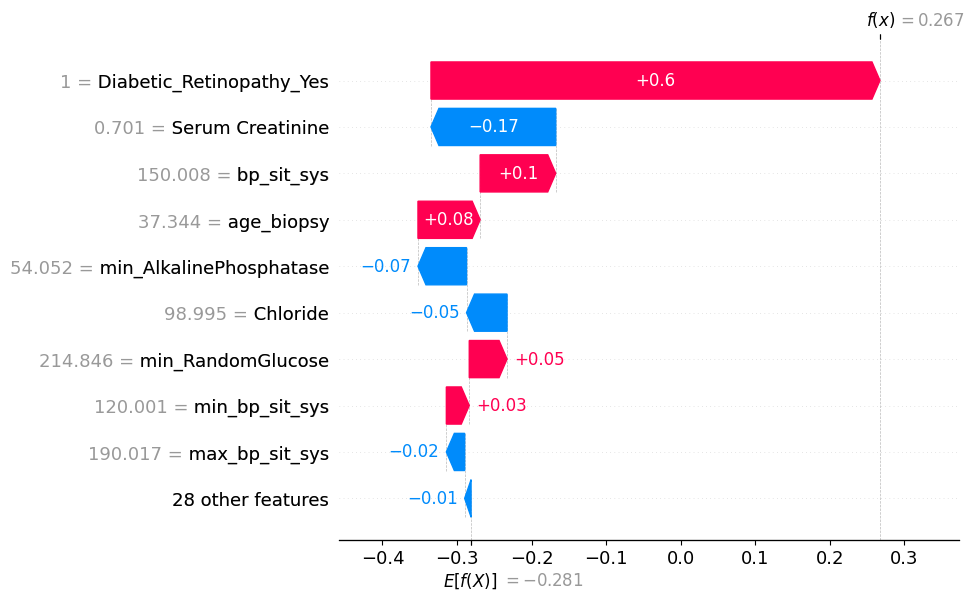

In [6]:
df_model = pd.read_csv(f'{base_dir}raw_data/reprocessed_model_log.csv')

executionid = 1

file_name_base = str(df_model[df_model['ExecutionID'] == executionid][['aggregation_time','gap']].values[0][0]) + '_years_' + str(df_model[df_model['ExecutionID'] == executionid][['aggregation_time','gap']].values[0][1])    

# read the proceedure dictionary
proc_df = pd.read_csv(f'{base_dir}raw_data/proc_mapping_file.csv')
proc_dic = proc_df.set_index('procedure_code')['short_description'].to_dict()
proc_dic.update({"791.0": "Proteinuria", "250.00": "Type 2 diabetes mellitus without complications", "99211": "Office/outpatient visit-99211" , "99212": "Office/outpatient visit-99212", 
            "99213": "Office/outpatient visit-99213", "99214": "Office/outpatient visit-99214", "99215": "Office/outpatient visit-99215"})


#load the colnames
colnames = pd.read_csv(f'{base_dir}{suffix}{file_name_base}/column_header.csv', header = None)
colnames = colnames[0].tolist()

# removed '_TRUE' from colnames and adding proceedure names instead of codes
colnames = [i.rsplit('_TRUE', 1)[0] for i in colnames]
colnames = [proc_dic.get(item,item)  for item in colnames]

X = pd.read_csv(f'{base_dir}{suffix}{file_name_base}/train.csv', names=colnames, header=None)
Y = X.iloc[:,0]
X_train = X.iloc[:,1:] #drop the first column which is the outcome variable

X_val = pd.read_csv(f'{base_dir}{suffix}{file_name_base}/validation.csv', names=colnames, header=None)
Y_val = X_val.iloc[:,0]
X_val = X_val.iloc[:,1:] #drop the first column which is the outcome variable

stand = pd.read_csv(f'{base_dir}{suffix}{file_name_base}/standardization.csv', index_col = 0)

X_trainD = X_train
X_valD = X_val

#X_trainD = xgb.DMatrix(X_train.values)
#X_valD = xgb.DMatrix(X_val.values)

# load the model
model = xgb.XGBClassifier()
model.load_model(f'{base_dir}{suffix}{file_name_base}/model.json')


# make predictions for val data
y_pred_val = model.predict(X_valD) > 0.5

# plot and save confusion matrix
cm = confusion_matrix(Y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

end_pathname = f'{file_name_base}_cm.pdf'
pathname = f'{base_dir}{output_suffix}{end_pathname}'                          

disp.plot()
plt.title(file_name_base)
plt.savefig(pathname, bbox_inches = "tight")
plt.close()

# evaluate predictions
accuracy = accuracy_score(Y_val, y_pred_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

outcome_var = 'is_DN'

# create a prediction dataframe
pred_df = pd.DataFrame(Y_val)
pred_df['model_prediction'] = y_pred_val.tolist()

false_neg = np.where((pred_df[outcome_var]==1) & (pred_df['model_prediction']== False))[0].tolist()
false_pos = np.where((pred_df[outcome_var]==0) & (pred_df['model_prediction']== True))[0].tolist()

# calculate Shap values
explainer = shap.TreeExplainer(model)

shap_values_train = shap_values_convert_units(X_train, stand, explainer)
shap_values_val = shap_values_convert_units(X_val, stand, explainer)

shap_values_false_neg = shap_values_convert_units(X_val.iloc[false_neg], stand, explainer)
shap_values_false_pos = shap_values_convert_units(X_val.iloc[false_pos], stand, explainer)

# shap plot
end_pathname = f'{file_name_base}_beeswarm.pdf'
pathname = f'{base_dir}{output_suffix}{end_pathname}'                          

shap.summary_plot(shap_values_train, X_train, show=False)
plt.title(file_name_base)
plt.savefig(pathname, bbox_inches = "tight") # we can save a PDF of the figure if we want
plt.close()
#plt.show()

end_pathname = f'{file_name_base}_val_false_neg.pdf'
pathname = f'{base_dir}{output_suffix}{end_pathname}'
waterfall_enrich_plot(shap_values_false_neg, pathname)

end_pathname = f'{file_name_base}_val_false_pos.pdf'
pathname = f'{base_dir}{output_suffix}{end_pathname}'
waterfall_enrich_plot(shap_values_false_pos, pathname)

In [7]:
pd.show_versions()

Setuptools is replacing distutils.



INSTALLED VERSIONS
------------------
commit           : 87cfe4e38bafe7300a6003a1d18bd80f3f77c763
python           : 3.10.6.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.10.76-linuxkit
Version          : #1 SMP PREEMPT Mon Nov 8 11:22:26 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.5.0
numpy            : 1.23.3
pytz             : 2022.2.1
dateutil         : 2.8.2
setuptools       : 65.4.0
pip              : 22.2.2
Cython           : 0.29.32
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.9.1
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.5.0
pandas_datareader: None
bs4              : 4.11.1
bottleneck       : 1.3.5
b

In [ ]:
! pip list